# Определение перспективного тарифа для телеком-компании

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра».

Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

***

In [1]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 6)

import seaborn as sns

sns.set_context('notebook', font_scale=1.5)
sns.set_style('darkgrid', rc={'ytick.left':True, 'ytick.direction':'in',
                              'xtick.bottom':True, 'xtick.direction':'in'})

***

## Содержание:
* [1. Общая информация](#section_1)
* [2. Подготовка данных](#section_2)
* [3. Помесячная выручка с каждого пользователя](#section_3)

## 1. Общая информация <a class="anchor" id="section_1"></a>

In [2]:
users_df = pd.read_csv('datasets/users.csv')
messages_df = pd.read_csv('datasets/messages.csv')
calls_df = pd.read_csv('datasets/calls.csv')
internet_df = pd.read_csv('datasets/internet.csv', )
tariffs_df = pd.read_csv('datasets/tariffs.csv')

При попытке посмотреть `calls_df.info()` вышла следующая ошибка:

`TypeError: Cannot interpret '<attribute 'dtype' of 'numpy.generic' objects>' as a data type`

Похожая проблема обсуждалась __[здесь](https://github.com/numpy/numpy/issues/18355)__. В итоге (загадочным образом) помогло:

`conda install pandas`

Дальше разбираться не стал.

### users

In [3]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [4]:
users_df.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


- `user_id` — уникальный идентификатор пользователя

- `first_name` — имя пользователя

- `last_name` — фамилия пользователя

- `age` — возраст пользователя (годы)

- `reg_date` — дата подключения тарифа (день, месяц, год)

- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)

- `city` — город проживания пользователя

- `tarif` — название тарифного плана


> Много пропусков в `churn_date`, но они объяснены в описании данных

### messages

In [5]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [6]:
messages_df.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

In [7]:
print(f'Информация по сообщениям есть для {len(messages_df.user_id.unique()) / users_df.shape[0] :.0%} пользователей')

Информация по сообщениям есть для 85% пользователей


### calls

In [8]:
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [9]:
calls_df.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

In [10]:
print(f'Информация по звонкам есть для {len(calls_df.user_id.unique()) / users_df.shape[0] :.0%} пользователей')

Информация по звонкам есть для 98% пользователей


### internet

In [11]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [12]:
internet_df.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

In [13]:
print(f'Информация по интернет-сессиям есть для {len(internet_df.user_id.unique()) / users_df.shape[0] :.0%} пользователей')

Информация по интернет-сессиям есть для 99% пользователей


### tariffs

In [14]:
tariffs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [15]:
tariffs_df

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [16]:
# Поиск дубликатов в данных

for df in [users_df, messages_df, calls_df, internet_df, tariffs_df]:
    print(df.duplicated().sum())

0
0
0
0
0


### Вывод

> - Дубликаты в таблицах отсутствуют
> - Требуется преобразование типов данных в некоторых колонках

## 2. Подготовка данных <a class="anchor" id="section_2"></a>

In [17]:
def date_convert(dates):
    """
    Преобразование типа данных в `dates` по шаблону

    Args:
        dates (pd.Series): Исходная колонка с датами

    Returns:
        pd.Series: Преобразованная колонка
    """    

    return pd.to_datetime(dates, format='%Y-%m-%d', errors='coerce')

In [18]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [19]:
users_df['churn_date'] = users_df['churn_date'].apply(date_convert)
users_df['reg_date'] = users_df['reg_date'].apply(date_convert)


messages_df['message_date'] = messages_df['message_date'].apply(date_convert)
# В каком месяце совершено действие?
messages_df['month'] = messages_df['message_date'].dt.month
messages_df = messages_df.rename(columns={'id': 'message_id'})

calls_df['call_date'] = calls_df['call_date'].apply(date_convert)
# В каком месяце совершено действие?
calls_df['month'] = calls_df['call_date'].dt.month
calls_df = calls_df.rename(columns={'id': 'call_id'})

internet_df['session_date'] = internet_df['session_date'].apply(date_convert)
# В каком месяце совершено действие?
internet_df['month'] = internet_df['session_date'].dt.month
internet_df = internet_df.rename(columns={'id': 'session_id'})

# Проверка
for df in [users_df, messages_df, calls_df, internet_df]:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   message_id    123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 n

❓: Заметил, что apply() работает довольно медленно. Он выполняет операции поэлементно?

В таблице `internet_df` содержится колонка, дублирующая индексы. Вероятно, при сохранении датафрейма не был установлен флаг `index=False`.

Удалю эту колонку.

In [20]:
internet_df.columns

Index(['Unnamed: 0', 'session_id', 'mb_used', 'session_date', 'user_id',
       'month'],
      dtype='object')

In [21]:
internet_df = internet_df.drop(['Unnamed: 0'], axis=1)

# Проверка
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   session_id    149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
 4   month         149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


> - Привел колонки с датами к типу datetime64 (с учетом пропусков)
> - Убрал неинформативную колонку из `internet_df`

### Округление звонков

In [22]:
calls_df

,call_id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12
...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,12
202603,1499_216,2018-10-18,18.83,1499,10
202604,1499_217,2018-11-10,10.81,1499,11
202605,1499_218,2018-10-06,4.27,1499,10


In [23]:
# После округления в большую сторону поменяю тип на int
calls_df['duration'] = np.ceil(calls_df['duration']).astype(int)

calls_df

,call_id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
...,...,...,...,...,...
202602,1499_215,2018-12-26,1,1499,12
202603,1499_216,2018-10-18,19,1499,10
202604,1499_217,2018-11-10,11,1499,11
202605,1499_218,2018-10-06,5,1499,10


### Объединение данных в одну таблицу

In [24]:
for df in [users_df, messages_df, calls_df, internet_df]:
    print(df.columns)

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff'],
      dtype='object')
Index(['message_id', 'message_date', 'user_id', 'month'], dtype='object')
Index(['call_id', 'call_date', 'duration', 'user_id', 'month'], dtype='object')
Index(['session_id', 'mb_used', 'session_date', 'user_id', 'month'], dtype='object')


In [25]:
# Назначаю индекс для упрощения представления

users_df = users_df.set_index('user_id')
messages_df = messages_df.set_index('user_id')
calls_df = calls_df.set_index('user_id')
internet_df = internet_df.set_index('user_id')

In [26]:
user_calls = users_df[['tariff']].merge(calls_df, left_index=True, right_index=True)

user_calls

,tariff,call_id,call_date,duration,month
user_id,,,,,
1000,ultra,1000_0,2018-07-25,0,7
1000,ultra,1000_1,2018-08-17,0,8
1000,ultra,1000_2,2018-06-11,3,6
1000,ultra,1000_3,2018-09-21,14,9
1000,ultra,1000_4,2018-12-15,6,12
...,...,...,...,...,...
1499,smart,1499_215,2018-12-26,1,12
1499,smart,1499_216,2018-10-18,19,10
1499,smart,1499_217,2018-11-10,11,11


## 3. Помесячная выручка с каждого пользователя <a class="anchor" id="section_3"></a>

In [27]:
# Параметры тарифов
smart_minutes_limit = 500
smart_overpay_minute = 3

ultra_minutes_limit = 3000
ultra_overpay_minute = 1

### Количество сделанных звонков и израсходованных минут разговора по месяцам

Сначала разберусь с пользователями тарифа `smart`:

In [31]:
def calls_revenue(calls_tarif_df,
                  minutes_tariff,
                  overpay_minute):
    """
    Вычисляет суммарную выручку за звонки

    Args:
        calls_tarif_df (_type_): _description_
        minutes_tariff (_type_): _description_
        overpay_minute (_type_): _description_
        tariff_payment (_type_): _description_

    Returns:
        _type_: _description_
    """

    # Количество звонков и их совокупная длительность
    calls_stat_df = (
        calls_tarif_df
        .groupby([calls_tarif_df.index, 'month'])['duration']
        .agg(['count', 'sum'])
        )

    calls_stat_df.columns = ['calls_count', 'total_duration']

    # Остаток по минутам
    calls_stat_df['minutes_left'] = minutes_tariff - calls_stat_df['total_duration']

    # Перебор по минутам
    minutes_left = calls_stat_df['minutes_left']
    calls_stat_df['minutes_over'] = np.where(minutes_left < 0, minutes_left, 0)
    calls_stat_df['minutes_over'] = calls_stat_df['minutes_over'].abs()

    # Переплата по минутам
    calls_stat_df['call_overpay'] = calls_stat_df['minutes_over'] * overpay_minute

    return calls_stat_df

In [32]:
calls_smart_df = user_calls[user_calls['tariff']=='smart']

calls_smart_df

,tariff,call_id,call_date,duration,month
user_id,,,,,
1001,smart,1001_0,2018-11-13,11,11
1001,smart,1001_1,2018-12-14,16,12
1001,smart,1001_2,2018-11-20,3,11
1001,smart,1001_3,2018-12-27,8,12
1001,smart,1001_4,2018-11-19,20,11
...,...,...,...,...,...
1499,smart,1499_215,2018-12-26,1,12
1499,smart,1499_216,2018-10-18,19,10
1499,smart,1499_217,2018-11-10,11,11


In [33]:
smart_calls_revenue = calls_revenue(calls_tarif_df=calls_smart_df,
                                    minutes_tariff=smart_minutes_limit,
                                    overpay_minute=smart_overpay_minute)

smart_calls_revenue

calls_count  total_duration  minutes_left  minutes_over  \
user_id month                                                            
1001    11              59             430            70             0   
        12              63             414            86             0   
1002    6               15             117           383             0   
        7               26             214           286             0   
        8               42             289           211             0   
...                    ...             ...           ...           ...   
1498    10              41             247           253             0   
1499    9                9              70           430             0   
        10              68             449            51             0   
        11              74             612          -112           112   
        12              69             492             8             0   

               call_overpay  
user_id month                
1001    11                0  
        12                0  
1002    6                 0  
        7                 0  
        8                 0  
...                     ...  
1498    10                0  
1499    9                 0  
        10                0  
        11              336  
        12                0  

[2223 rows x 5 columns]

In [34]:
calls_ultra_df = user_calls[user_calls['tariff']=='ultra']

calls_ultra_df.shape

(72292, 5)

In [35]:
ultra_calls_revenue = calls_revenue(calls_tarif_df=calls_ultra_df,
                                    minutes_tariff=ultra_minutes_limit,
                                    overpay_minute=ultra_overpay_minute)

ultra_calls_revenue

calls_count  total_duration  minutes_left  minutes_over  \
user_id month                                                            
1000    5               22             159          2841             0   
        6               43             172          2828             0   
        7               47             340          2660             0   
        8               52             408          2592             0   
        9               58             466          2534             0   
...                    ...             ...           ...           ...   
1495    8               17              92          2908             0   
        9              112             813          2187             0   
        10             152            1030          1970             0   
        11             129             954          2046             0   
        12             155            1031          1969             0   

               call_overpay  
user_id month                
1000    5                 0  
        6                 0  
        7                 0  
        8                 0  
        9                 0  
...                     ...  
1495    8                 0  
        9                 0  
        10                0  
        11                0  
        12                0  

[951 rows x 5 columns]

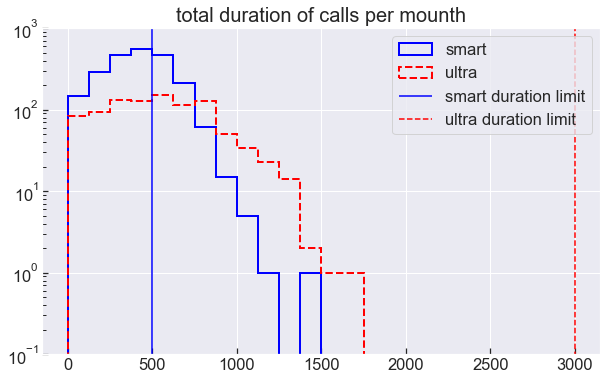

In [36]:
fig, ax = plt.subplots()

space = np.linspace(0, 1750, 15)

ax.hist(smart_calls_revenue['total_duration'], histtype='step',
        color='blue', bins=space, lw=2, label='smart')
ax.hist(ultra_calls_revenue['total_duration'], histtype='step',
        color='red', bins=space, lw=2, ls='--', label='ultra')

ax.set_title('total duration of calls per mounth', fontsize=20)

ax.vlines(smart_minutes_limit, 0, 1e3, color='blue',
          label='smart duration limit')
ax.vlines(ultra_minutes_limit, 0, 1e3, color='red', ls='--',
          label='ultra duration limit')

ax.legend()
ax.set_yscale('log')

ax.set_ylim(.1, 1e3)

plt.show()

Более чем в 30% от общего количества месяцев, для которых есть данные, пользователи тарифа Смарт доплачивали за минуты сверх пакета. Такие случае отсутствуют для пользователей тарифа Ультра -- там пользователи наговаривают максимум на 56% от минут в своем пакете (3000).

### Количество отправленных сообщений по месяцам

In [37]:
smart_sms_limit = 50
smart_sms_overpay = 3

ultra_sms_limit = 1000
ultra_sms_overpay = 1

In [38]:
user_sms_df = users_df[['tariff']].merge(messages_df, left_index=True, right_index=True)

user_sms_df

,tariff,message_id,message_date,month
user_id,,,,
1000,ultra,1000_0,2018-06-27,6
1000,ultra,1000_1,2018-10-08,10
1000,ultra,1000_2,2018-08-04,8
1000,ultra,1000_3,2018-06-16,6
1000,ultra,1000_4,2018-12-05,12
...,...,...,...,...
1499,smart,1499_179,2018-12-12,12
1499,smart,1499_180,2018-09-28,9
1499,smart,1499_181,2018-09-27,9


In [39]:
smart_sms_df = user_sms_df[user_sms_df['tariff'] == 'smart']
ultra_sms_df = user_sms_df[user_sms_df['tariff'] == 'ultra']

print(f'{smart_sms_df.shape[0]} сообщений отправлено пользователями тарифа smart')
print(f'{ultra_sms_df.shape[0]} сообщений отправлено пользователями тарифа ultra')

74413 сообщений отправлено пользователями тарифа smart
48623 сообщений отправлено пользователями тарифа ultra


In [41]:
def sms_revenue(sms_tariff_df, sms_limit, sms_overpay):

    # Количество звонков и их совокупная длительность
    sms_stat_df = (
        sms_tariff_df
        .groupby([sms_tariff_df.index, 'month'])['message_id'].count()
        )

    sms_stat_df = pd.DataFrame(sms_stat_df)
    sms_stat_df.columns = ['messages_count']

    # Остаток по сообщениям
    sms_stat_df['sms_left'] = sms_limit - sms_stat_df['messages_count']

    # Перебор по сообщениям
    sms_left = sms_stat_df['sms_left']
    sms_stat_df['sms_over'] = np.where(sms_left < 0, sms_left, 0)
    sms_stat_df['sms_over'] = sms_stat_df['sms_over'].abs()

    # Переплата по сообщениям
    sms_stat_df['sms_overpay'] = sms_stat_df['sms_over'] * sms_overpay

    return sms_stat_df

In [42]:
smart_sms_stat_df = sms_revenue(smart_sms_df,
                                sms_limit=smart_sms_limit,
                                sms_overpay=smart_sms_overpay)

smart_sms_stat_df

messages_count  sms_left  sms_over  sms_overpay
user_id month                                                 
1002    6                   4        46         0            0
        7                  11        39         0            0
        8                  13        37         0            0
        9                   4        46         0            0
        10                 10        40         0            0
...                       ...       ...       ...          ...
1498    10                 42         8         0            0
1499    9                  11        39         0            0
        10                 48         2         0            0
        11                 59        -9         9           27
        12                 66       -16        16           48

[1922 rows x 4 columns]

In [43]:
ultra_sms_stat_df = sms_revenue(ultra_sms_df,
                                sms_limit=ultra_sms_limit,
                                sms_overpay=ultra_sms_overpay)

ultra_sms_stat_df

messages_count  sms_left  sms_over  sms_overpay
user_id month                                                 
1000    5                  22       978         0            0
        6                  60       940         0            0
        7                  75       925         0            0
        8                  81       919         0            0
        9                  57       943         0            0
...                       ...       ...       ...          ...
1495    8                  13       987         0            0
        9                  82       918         0            0
        10                 82       918         0            0
        11                 79       921         0            0
        12                 84       916         0            0

[795 rows x 4 columns]

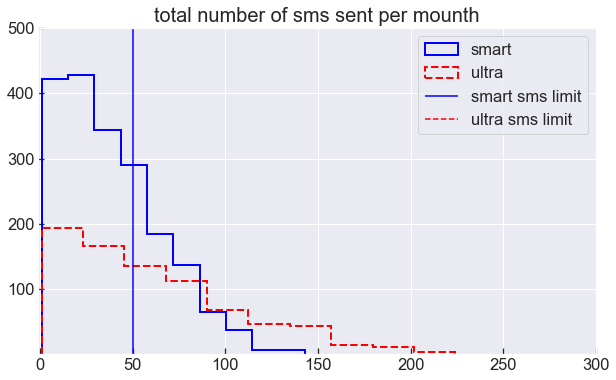

In [44]:
fig, ax = plt.subplots()

# space = np.linspace(0, 1750, 15)

ax.hist(smart_sms_stat_df['messages_count'], histtype='step',
        color='blue', lw=2, label='smart')
ax.hist(ultra_sms_stat_df['messages_count'], histtype='step',
        color='red', lw=2, ls='--', label='ultra')

ax.set_title('total number of sms sent per mounth', fontsize=20)

ax.vlines(smart_sms_limit, 0, 1e3, color='blue',
          label='smart sms limit')
ax.vlines(ultra_sms_limit, 0, 1e3, color='red', ls='--',
          label='ultra sms limit')

ax.legend()
# ax.set_xscale('log')

ax.set_xlim(-1, 300)
ax.set_ylim(.1, 500)

plt.show()

Достаточно часто в данных встречаются месяцы, в которые пользователи тарифа `smart` вышли за предел количества sms, предусмотренных тарифом. Такого не наблюдается для пользователей тарифа `ultra` --- максимальноее количество sms, отправленных такими пользователями в месяц не превышает 230 (лимит по этому тарифу 3000).

### Трафик и выручка с каждого пользователя

In [45]:
smart_web_limit = 15
smart_web_overpay = 200

ultra_web_limit = 30
ultra_web_overpay = 150

In [46]:
user_web_df = users_df[['tariff']].merge(internet_df, left_index=True, right_index=True)

user_web_df

,tariff,session_id,mb_used,session_date,month
user_id,,,,,
1000,ultra,1000_0,112.95,2018-11-25,11
1000,ultra,1000_1,1052.81,2018-09-07,9
1000,ultra,1000_2,1197.26,2018-06-25,6
1000,ultra,1000_3,550.27,2018-08-22,8
1000,ultra,1000_4,302.56,2018-09-24,9
...,...,...,...,...,...
1499,smart,1499_152,318.90,2018-10-03,10
1499,smart,1499_153,490.13,2018-12-14,12
1499,smart,1499_154,0.00,2018-10-27,10


In [47]:
smart_web_df = user_web_df[user_web_df['tariff'] == 'smart']
ultra_web_df = user_web_df[user_web_df['tariff'] == 'ultra']

In [48]:
tarif_web_df = smart_web_df
gb_overpay = smart_web_overpay
gb_limit = smart_web_limit

web_stat_df = (
            tarif_web_df
            .groupby([tarif_web_df.index, 'month'])['mb_used']
            .agg(['count', 'sum'])
            )

web_stat_df.columns = ['session_count', 'mb_month']

# Гигабайт использовано в месяц каждым пользователем
web_stat_df['Gb_month'] = web_stat_df['mb_month'] / 1024

# Округляю гигабайты в большую сторону и привожу к целочисленному типу
web_stat_df['Gb_month'] = np.ceil(web_stat_df['Gb_month']).astype(int)

# Сколько гигабайт осталось?
web_stat_df['Gb_left'] = web_stat_df['Gb_month'] - gb_limit
web_left = web_stat_df['Gb_left']

web_stat_df['Gb_overpay'] = np.where(web_left < 0, web_left, 0)
web_stat_df['Gb_overpay'] = web_stat_df['Gb_overpay'].abs()

# Сколько пользователь переплатит за интернет?
web_stat_df['Gb_overpay'] = web_stat_df['Gb_overpay'] * gb_overpay

web_stat_df

session_count  mb_month  Gb_month  Gb_left  Gb_overpay
user_id month                                                        
1001    11                55  18429.34        18        3           0
        12                41  14036.66        14       -1         200
1002    6                 34  10856.82        11       -4         800
        7                 58  17580.10        18        3           0
        8                 60  20319.26        20        5           0
...                      ...       ...       ...      ...         ...
1498    10                59  20579.36        21        6           0
1499    9                  5   1845.75         2      -13        2600
        10                58  17788.51        18        3           0
        11                49  17963.31        18        3           0
        12                45  13055.58        13       -2         400

[2228 rows x 5 columns]

In [49]:
smart_sms_stat_df

messages_count  sms_left  sms_over  sms_overpay
user_id month                                                 
1002    6                   4        46         0            0
        7                  11        39         0            0
        8                  13        37         0            0
        9                   4        46         0            0
        10                 10        40         0            0
...                       ...       ...       ...          ...
1498    10                 42         8         0            0
1499    9                  11        39         0            0
        10                 48         2         0            0
        11                 59        -9         9           27
        12                 66       -16        16           48

[1922 rows x 4 columns]

In [51]:
web_stat_df.merge(smart_sms_stat_df, left_index=True, right_index=True, how='left')

session_count  mb_month  Gb_month  Gb_left  Gb_overpay  \
user_id month                                                           
1001    11                55  18429.34        18        3           0   
        12                41  14036.66        14       -1         200   
1002    6                 34  10856.82        11       -4         800   
        7                 58  17580.10        18        3           0   
        8                 60  20319.26        20        5           0   
...                      ...       ...       ...      ...         ...   
1498    10                59  20579.36        21        6           0   
1499    9                  5   1845.75         2      -13        2600   
        10                58  17788.51        18        3           0   
        11                49  17963.31        18        3           0   
        12                45  13055.58        13       -2         400   

               messages_count  sms_left  sms_over  sms_overpay  
user_id month                                                   
1001    11                NaN       NaN       NaN          NaN  
        12                NaN       NaN       NaN          NaN  
1002    6                 4.0      46.0       0.0          0.0  
        7                11.0      39.0       0.0          0.0  
        8                13.0      37.0       0.0          0.0  
...                       ...       ...       ...          ...  
1498    10               42.0       8.0       0.0          0.0  
1499    9                11.0      39.0       0.0          0.0  
        10               48.0       2.0       0.0          0.0  
        11               59.0      -9.0       9.0         27.0  
        12               66.0     -16.0      16.0         48.0  

[2228 rows x 9 columns]

In [ ]:
smart_tariff_price = 550
ultra_tariff_price = 1950